# Projeto Kaggle: Diabetic Retinopathy Classification F1 Score #4

## Introdução
Este relatório é referente ao ["Diabetic Retinopathy Classification F1 Score #4"](https://www.kaggle.com/competitions/diabetic-retinopathy-classification-f1-score-4), um desafio proposto pela comunidade do Kaggle que tem como objetivo desenvolver um classificador de imagem que identifique a retinopatia diabética (RD) no olho de um paciente.

A RD, uma complicação ocular relacionada com a diabetes, apresenta sérios riscos à visão e pode levar à cegueira se não for detectada e tratada de forma precoce e eficaz.

## Conjunto de Dados

O conjunto de dados consiste em 2197 imagens utilizadas para treino e validação, cada uma associada a uma classe específica. Estas anotações estão indicadas num ficheiro CSV, chamado train.csv, com as seguintes colunas:

- image_id, que corresponde ao nome da imagem
- diagnosis, que corresponde à classe atribuída

Além disso, um conjunto de teste com 1465 imagens foi disponibilizado para a geração de previsões, as quais deverão ser submetidas no desafio em formato CSV com a mesma estrutura que o train.csv.

As classes estão representadas pelos números entre 0 e 4, sendo estas referentes ao grau de gravidade da retinopatia diabética observada.

- 0: Sem retinopatia aparente
- 1: RD não proliferativa ligeira
- 2: RD não proliferativa moderada
- 3: RD não proliferativa grave
- 4: RD proliferativa

Pretende-se que o modelo atribua uma destas cinco classes a cada imagem, podendo obter o grau de retinopatia diabética presente. Esta abordagem de classificação em múltiplas classes permite uma análise mais detalhada da progressão da doença e orienta decisões clínicas sobre intervenções e tratamentos adequados.

Os dados foram fornecidos pelo desafio e guardados na pasta input/.

## Ferramentas

Para o desenvolvimento do modelo, recorreu-se às bibliotecas Tensorflow e Keras.

O sckit-learn foi usado meramente para realizar a separação do conjunto de dados entre train e validation.

Abaixo seguem o comando, usando o gestor de pacotes pip, para a instalação das bibliotecas no ambiente.

In [ ]:
!pip install pandas matplotlib numpy Pillow tensorflow scikit-learn

## Pré-processamento de Dados

Nesta primeira etapa de pré-processamento, foi feita a leitura do CSV usando a função read_csv() do Pandas.

A partir desta informação, podemos obter todas as classes presentes no dataset e obter as labels associadas a cada imagem numa lista.

De seguida, faz-se a divisão em conjuntos de treino e validação numa proporção de 80/20.

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Definição das diretorias do dataset
input_path = "input/diabetic-retinopathy-classification-f1-score-4/kaggle_retina"

train_data_path = input_path + "/train"
test_path = os.path.join(input_path, "test")

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_data = pd.read_csv(input_path + '/train.csv')
classes = train_data['diagnosis'].unique()
class_to_label = {class_name: i for i, class_name in enumerate(classes)}
labels = [label for label in train_data['diagnosis']]

train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_data['id_code'].apply(lambda x: os.path.join(train_data_path, x + ".png")),
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [13]:
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})

class_counts = train_df['label'].value_counts().reset_index()
class_counts.columns = ['class', 'count']
class_counts = class_counts.sort_values(by='class')
print(class_counts.to_string(index=False))

 class  count
     0    866
     1    177
     2    479
     3     93
     4    142


## Data Augmentation

Após o pré-processamento, segue-se a Data Augmentation, uma técnica utilizada no treino de modelos de aprendizagem profunda para melhorar a generalização do modelo, aplicando transformações aleatórias nas imagens e criar novas variações das mesmas.

No código abaixo, são aplicadas transformações como rotação, cisalhamento, zoom, espelhamento horizontal e descolamentos.

Para finalizar, é criado um iterador de DataFrames em batches de 32 com o caminho das imagens e as labels. As imagens são também redimensionadas, neste caso para 180 píxeis de largura e de altura.

Para além destas dimensões, foram à parte testados outros valores, como 50x50 e 300x300. Por um lado, com imagens de dimensões menores, o tempo de treino é drasticamente reduzido e os resultados no treino pouco diferiram do apresentado abaixo. Por outro lado, é esperado, mas não garantido, que maiores dimensões resultem num modelo mais eficiente, com o inconveniente que o treino fica mais lento. Infelizmente, com as dimensões de 300x300, não foram verificadas melhorias ao longo dos nossos testes.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 32
img_height = 180
img_width = 180

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': train_paths, 'label': [str(label) for label in train_labels]}),
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': valid_paths, 'label': [str(label) for label in valid_labels]}),
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse'
)

Found 1757 validated image filenames belonging to 5 classes.
Found 440 validated image filenames belonging to 5 classes.


## Construção e Compilação do Modelo

Com os dados estruturados, segue a construção e a compilação do modelo, onde é definida a arquitetura a ser utilizada e, de seguida: o otimizador, a função de perda e as métricas.

O nosso modelo que melhor resultado teve na competição, bem como os melhores valores de validation loss e validation accuracy, foi uma Rede Neural Convolucional (CNN) simples representada pelo código abaixo.

O otimizador Adam (Adaptive Moment Estimation) é um dos algoritmos mais populares de otimização devido à sua eficácia numa variedade de cenários.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
	layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dropout (Dropout)           (None, 118336)            

## Treino do Modelo

Com o modelo compilado, segue-se o treino com 10 épocas. Foram testados valores maiores para diferentes learning rates. Para o learning rate predefinido do Adam (0.001), mais do que 10 épocas não melhora os resultados.

Para valores mais baixos de learning rate, pode ser necessário um número de épocas maiores mas, pelos nossos testes, 20 chegava.

In [5]:
epochs=10

history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs
)

Epoch 1/10
55/55 [==============================] - 43s 762ms/step - loss: 1.3998 - accuracy: 0.5532 - val_loss: 0.9105 - val_accuracy: 0.7136
Epoch 2/10
55/55 [==============================] - 17s 314ms/step - loss: 0.8687 - accuracy: 0.6853 - val_loss: 0.8595 - val_accuracy: 0.6886
Epoch 3/10
55/55 [==============================] - 17s 313ms/step - loss: 0.8510 - accuracy: 0.7006 - val_loss: 0.8225 - val_accuracy: 0.7386
Epoch 4/10
55/55 [==============================] - 17s 313ms/step - loss: 0.8161 - accuracy: 0.7126 - val_loss: 0.8606 - val_accuracy: 0.7114
Epoch 5/10
55/55 [==============================] - 17s 313ms/step - loss: 0.7920 - accuracy: 0.7109 - val_loss: 0.8923 - val_accuracy: 0.7114
Epoch 6/10
55/55 [==============================] - 17s 310ms/step - loss: 0.7809 - accuracy: 0.7177 - val_loss: 0.8022 - val_accuracy: 0.7227
Epoch 7/10
55/55 [==============================] - 17s 313ms/step - loss: 0.7695 - accuracy: 0.7348 - val_loss: 0.7787 - val_accuracy: 0.7341

## Análise de Resultados

O código e os resultados fornecidos estão relacionados com a avaliação do modelo anterior, utilizando o conjunto de dados que foi usado para a validação do modelo.

Num cenário ideal, seria usado o conjunto de dados de testes. O conjunto de validação é útil para o ajuste de hiperparametros e a monitorização do desempenho do modelo em dados não vistos, de forma a evitar o overfitting e a generalização do modelo. O conjunto de teste serve para uma avaliação final, no entanto, o nosso conjunto de teste não inclui ground truth. As competições do Kaggle não fornecem esta informação de modo a evitar submissões fraudulentas. O conjunto de dados é, por outro lado, considerado uma alternativa aceitável mas, corre-se o risco de termos resultados inflacionados devido à tendência do modelo otimizar a sua configuração para a validação.

Os resultados abaixo indicam que, no conjunto de validação:
- A perda é de aproximadamente 0.7914
- A acurácia é de aproximadamente 71.59%

A perda representa o quão bem o modelo consegue minimizar o erro durante a previsão. A acurácia mostra a proporção de previsões corretas em relação ao total de exemplos.

Não temos uma baseline para este conjunto e nesta competição que possamos usar para fazer uma avaliação. Mesmo analisando soluções obtidas noutras competições e em papers, a comparação é difícil, visto que muitos possuem também conjuntos nas dezenas de milhares de imagens e com melhor qualidade. Nomeadamente, noutras competições, as melhores soluções tendem a usar não só o conjunto de dados fornecido pela competição, como aproveitam conjuntos de fora para melhorar os resultados. Os resultados de muitas destas soluçãos provam que é possível atingir uma acurácia acima de 99% recorrendo redes neurais como ResNet50, EfficientNet, MobileNet, etc. Na nossa experiência, possivelmente devido ao conjunto de dados de tamanho reduzido, os resultados não melhoraram usando estas redes.

Um exemplo destas soluções é o [paper de Dolly Das et al. "Detection of Diabetic Retinopathy using Convolutional Neural Networks for Feature Extraction and Classification (DRFEC)"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9708148/)

Podemos ver nos gráficos de perda e acurácia que, ao longo das épocas, o modelo vai-se reajustando, conseguindo reduzir a loss e aumentar a acurácia. Este valor estagna nas épocas finais, tornando o aumento do número de épocas um custo computacional desnecessário.

In [7]:
evaluation_result = model.evaluate(valid_generator)

print("Validation Loss:", evaluation_result[0])
print("Validation Accuracy:", evaluation_result[1])

14/14 [==============================] - 1s 93ms/step - loss: 0.7914 - accuracy: 0.7159
Validation Loss: 0.7914184331893921
Validation Accuracy: 0.7159090638160706


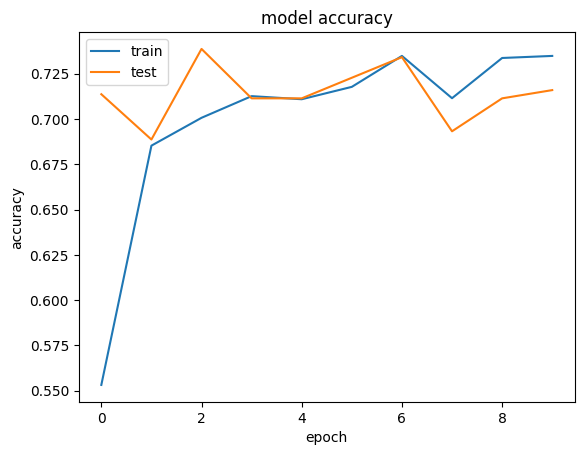

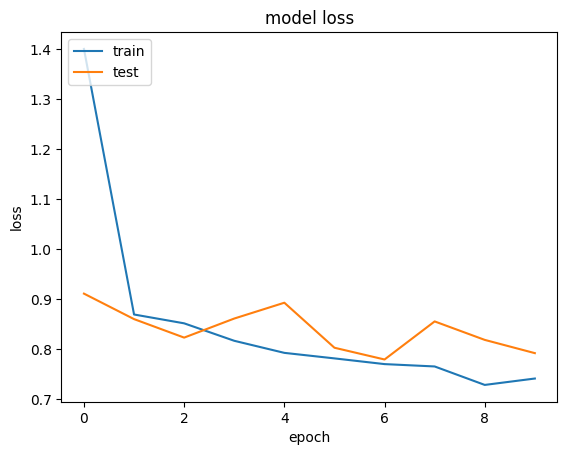

In [6]:
import matplotlib.pyplot as plt


# Gráfico da precisão do modelo ao longo das épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resumo do histórico de perda do modelo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Submissão

O código abaixo utiliza o modelo treinado para fazer previsões em todas as imagens do conjunto de testes e gerar o ficheiro CSV a submeter no Kaggle.

In [8]:
test_filenames = os.listdir(test_path)

ids = []
predictions = []

for filename in test_filenames:
    img_path = os.path.join(test_path, filename)
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    ids.append(filename.replace('.png', ''))
    predictions.append(predicted_class)
    
result_df = pd.DataFrame({'id_code': ids, 'diagnosis': predictions})

result_df.to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 18ms/step


## Exploração de soluções

Foram exploradas outras soluções com o intuito de obter melhores resultados. Testámos as arquiteturas ResNet50 e EfficientNetV2 que, principalmente a segunda, foram também aplicadas noutros problemas de deteção de retinopatia diabética, tendo obtido excelentes resultados. No entanto, os valores de perda e de acurácia mantiveram-se iguais às da nossa primeira CNN.

Foram ainda testados, tanto para a CNN simples como nessas arquiteturas, diversos hiperparâmetros, nomeadamente o learning rate, mas sem sucesso. Learning rates mais altos aumentou a loss, enquanto que learning rates mais baixos simplesmente necessitavam de mais épocas para aproximar os valores ao que obtivemos originalmente.

Por outro lado, excluir as classes que tinham um número reduzido de imagens associadas melhorou imenso os resultados para as restantes, tendo superado uma acurácia de 80% e a perda caiu para ~0,45.

Abaixo segue um excerto de código representativo das alternativas exploradas.

In [9]:
from tensorflow.keras.applications import EfficientNetV2B1
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3), pooling='max')

# from tensorflow.keras.applications.resnet50 import ResNet50
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.4, seed=123),
    layers.Dense(len(classes), activation='softmax')
])


## Conclusão

O desenvolvimento e treino de um modelo de classificação de retinopatia diabética revelou-se um desafio significativo. O modelo proposto, CNN simples apresentou resultados razoáveis, com uma perda de aproximadamente 0.7914 e uma acurácia de cerca de 71.59% no conjunto de validação.

A adição de técnicas de Data Augmentation, o uso de modelos pré-treinados e os diversos ajustes aos hiperparâmetros nãp proporcionaram significativas na generalização do modelo, apesar das soluções apresentadas terem sido já exploradas neste contexto em investigações por terceiros.

O facto que a exclusão das imagens com as duas classes de menor frequência fez com que os resultados melhorassem drasticamente, leva-nos a concluir que o principal problema encontra-se nas dimensões do conjunto de dados e, principalmente, no seu desequilíbrio. As classes 3 e 4, que têm 93 e 142 imagens respetivamente, que num vácuo são valores baixos, destacam-se comparados à classe 0 com 866 imagens.

Não foi possível realizar uma avaliação correta do modelo dadas as limitações impostas pelo Kaggle, visto que o conjunto de testes não possui anotações. Como a avaliação foi feita com o conjunto de validação, existe a possibilidade de estarmos presentes de resultados acima do real devido à tendência que o modelo tem para estes. Uma solução seria fragmentar o conjunto de treino numa terceira parte mas, correndo o risco de agravar o problema do conjunto desequilibrado.

Num trabalho futuro, aumentar o conjunto de dados e equilibrá-los poderá permitir a criação de um modelo mais eficiente na deteção de retinopatia diabética. As melhorias à arquitetura da CNN, a exploração de modelos pré-treinados e os ajustes dos hiperparâmetros podem demonstrar resultados mais promissores.

## Bibliografia

Das D, Biswas SK, Bandyopadhyay S. Detection of Diabetic Retinopathy using Convolutional Neural Networks for Feature Extraction and Classification (DRFEC). Multimed Tools Appl. 2022 Nov 29:1-59. doi: 10.1007/s11042-022-14165-4. Epub ahead of print. PMID: 36467440; PMCID: PMC9708148.